In [1]:
import sys
sys.path.append('../')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from archived.seq2seq.model_seq2seq import *
from utils import Doc, read
from attribute import TFIDFKeywordExtractor

Model loaded succeed
use_cuda  True


In [2]:
#dev_lyrics = read()[:500]
# Doc.load_corpus(dev_lyrics)
Doc.load()

In [3]:
len(Doc.get_vocab())

10000

In [4]:
symbols = ['PAD', 'SOS', 'EOS']
Doc.extend_vocab(symbols)
vocab = Doc.get_vocab()
print(len(vocab))
for symbol in symbols:
    print(vocab[symbol])
print(Doc.idxs_to_text(vocab['PAD']))

10003
10000
10001
10002
PAD


In [5]:
# # Doc.text_to_idxs("EOS_token")
# len(Doc.get_vocab())
# Doc.text_to_idxs("一万")
# Doc.idxs_to_text(np.array([2]))

In [6]:
# special_words = {
#     "SOS_token": 0,
#     "EOS_token": 1,
#     "PAD_token": 2
#                 }
# # a = Doc.get_vocab()

In [7]:
list_of_list_of_lines = [doc.get_lines() for doc in Doc.get_corpus()]
# e = TFIDFKeywordExtractor(list_of_list_of_lines, len(Doc.get_vocab()))
#e.get_keywords()

In [8]:
text_sample = list_of_list_of_lines
# print(Doc.idxs_to_text(text_sample[0]))
keywords = TFIDFKeywordExtractor(text_sample, len(Doc.get_vocab()),n_keywords = 1)
keywords.get_keywords()
pairs = list(zip([i for j in keywords.get_keywords() for i in j],\
            [i for j in text_sample for i in j]))

In [9]:
hidden_size = 512
teacher_forcing_ratio = 0.5
MIN_LENGTH = 0
MAX_LENGTH = 40
BATCH_SIZE = 32
# SOS_token = 0
# EOS_token = 1
# PAD_token = 2



use_cuda = torch.cuda.is_available()

def keywords_filterPair(p):
    return MIN_LENGTH < len(p[0]) < MAX_LENGTH and \
        MIN_LENGTH < len(p[1]) < MAX_LENGTH

def keywords_filterPairs(pairs):
    return [pair for pair in pairs if keywords_filterPair(pair)]

In [10]:
filtered_pairs = keywords_filterPairs(pairs)

In [11]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [12]:
from sklearn.cross_validation import train_test_split
train_input,val_input, _, __ =  \
    train_test_split(filtered_pairs,np.zeros(np.array(filtered_pairs).shape),test_size=0.2, random_state=0)
    

/home/jinxingyu/anaconda2/envs/lyrics/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [13]:
def earlystopping(loss_list, patience):
    if len(loss_list)> patience:
        loss_diff = np.array(loss_list[1:]) - np.array(loss_list[:-1])
        if loss_diff[(-1)*patience:].all() > 0:
            return True
    return False

In [14]:
def trainIters(encoder, decoder,train_input, val_input,vocab, n_iters = 2000, patience = 10, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_train_losses = []
    print_train_loss_total = 0  # Reset every print_every
    plot_train_loss_total = 0  # Reset every plot_every
    
    plot_val_losses = []
    print_val_loss_total = 0  # Reset every print_every
    plot_val_loss_total = 0  # Reset every plot_every
    

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pairs = [keywords_variablesFromPair(random.choice(train_input)) for i in range(BATCH_SIZE)]
        train_input_variable = torch.cat([pair[0] for pair in training_pairs], 1)
        train_target_variable = torch.cat([pair[1] for pair in training_pairs], 1)
        
        train_loss = train(train_input_variable, train_target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion, vocab)
        print_train_loss_total += train_loss
        plot_train_loss_total += train_loss

        val_pairs = [keywords_variablesFromPair(random.choice(val_input)) for i in range(BATCH_SIZE)]
        val_input_variable = torch.cat([pair[0] for pair in val_pairs], 1)
        val_target_variable = torch.cat([pair[1] for pair in val_pairs], 1)
        val_loss = evaluate(val_input_variable, val_target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion, vocab)
        print_val_loss_total += val_loss
        plot_val_loss_total += val_loss
        
        
        if iter % print_every == 0:
            print_train_loss_avg = print_train_loss_total / print_every
            print_train_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_train_loss_avg))
            print_val_loss_avg = print_val_loss_total / print_every
            print_val_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_val_loss_avg))

        if iter % plot_every == 0:
            plot_train_loss_avg = plot_train_loss_total / plot_every
            plot_train_losses.append(plot_train_loss_avg)
            plot_train_loss_total = 0
            
            plot_val_loss_avg = plot_val_loss_total / plot_every
            plot_val_losses.append(plot_val_loss_avg)
            plot_val_loss_total = 0
            if earlystopping(plot_val_losses, patience) == True:
                print("Training process stopped due to earlystopping with patience ", patience)
                break
            predictRandomly(encoder, decoder, val_input, vocab)
            showPlot(plot_train_losses,plot_val_losses)

In [15]:
def keywords_variableFromIndex(indexes, reverse=False):
    indexes = indexes.tolist()
    indexes.append(vocab['EOS'])
    indexes = [vocab['PAD']] * (MAX_LENGTH - len(indexes)) + indexes
    if reverse:
        indexes = indexes[::-1]
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    if use_cuda:
        return result.cuda()
    else:
        return result


def keywords_variablesFromPair(pair):
    input_variable = keywords_variableFromIndex(pair[0])
    target_variable = keywords_variableFromIndex(pair[1], False)
    return (input_variable, target_variable)

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points1, points2 = []):
#     plt.figure()
#     fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
#     loc = ticker.MultipleLocator(base=0.2)
#     ax.yaxis.set_major_locator(loc)
    plt.plot(points1)
    plt.plot(points2)
    plt.show()

In [17]:
def predict(encoder, decoder, input_variable,vocab, max_length=MAX_LENGTH, beam_width=30):
    input_length = len(input_variable)
    encoder_hidden = encoder.initHidden(beam_width)

    input_variable = torch.cat([input_variable for i in range(beam_width)], 1)

    encoder_outputs = Variable(torch.zeros(beam_width, max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],
                                                 encoder_hidden)
        encoder_outputs[:, ei] = encoder_output[0]

    decoder_input = Variable(torch.LongTensor([[vocab['SOS']]] * beam_width))  # SOS
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden
    decoder_hidden_copy = Variable(torch.zeros(encoder1.n_layers, beam_width, hidden_size))
    decoder_hidden_copy = decoder_hidden_copy.cuda() if use_cuda else decoder_hidden_copy
    
    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    probability = torch.zeros(beam_width).view(-1, 1)
    probability = probability.cuda() if use_cuda else probability
    
    prev = [[]] * max_length
    idxs = [[]] * max_length
    
    cands = []
    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)

#       LogSoftmax
        topv, topi = decoder_output.data.topk(beam_width)

        if di == 0:
            decoder_input = Variable(torch.LongTensor([[ni] for ni in topi[0]]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input
            probability = topv[0].view(-1, 1)
        else:
#           Get beam_width candidate for each beam.
            topv = topv + probability
            topv, topi = topv.view(-1), topi.view(-1)

#           Select beam_width from beam_width*beam_width.
            _, topt = topv.topk(beam_width)

#           Update adn prepare for the next step.
            probability = topv[topt]
            decoder_input = Variable(torch.LongTensor([[topi[topt[k]]] for k in range(beam_width)]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input
            prev[di] = [topt[k] // beam_width for k in range(beam_width)]
            
#           Don't forget to prepare the corresponding hidden state.
            for i in range(beam_width):
                decoder_hidden_copy[:, i] = decoder_hidden[:, prev[di][i]]
            decoder_hidden = decoder_hidden_copy.clone()
            
#           If some beam meets its end.

            for i in range(beam_width):
                if decoder_input.data[i, 0] == vocab['PAD'] and probability[i] > -np.inf:
                    cands.append((probability[i], di, i))
                    probability[i] = -np.inf

#       Record each step's input
        idxs[di] = decoder_input.data
        
    def full_sentence(start, di):
        decoded_words = []
        for loc in range(1, di+1)[::-1]:
            #print([idxs[loc][start][0]])
            #print(Doc.idxs_to_text(np.array([idxs[loc][start][0]])))
            decoded_words = [Doc.idxs_to_text(np.array([idxs[loc][start][0]]))] + decoded_words
            start = prev[loc][start]
        return ''.join(decoded_words).replace('PAD', '')[::-1]

    cands = sorted(cands)[::-1]

    cands = list(map(lambda x: full_sentence(x[2], x[1]), cands))
    
    answers = []
    for cand in cands:
        if cand not in answers:
            answers.append(cand)

    return answers, decoder_attentions[:di + 1]        
        

def predictRandomly(encoder, decoder,pairs,vocab, n=5, beam_width=30, show=5):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', Doc.idxs_to_text(pair[0]))
        print('=', Doc.idxs_to_text(pair[1]))
        output_sentences, attentions = predict(encoder, decoder, keywords_variableFromIndex(pair[0]),vocab, beam_width=beam_width)
        for j in range(min(len(output_sentences), show)):
            print('<', output_sentences[j])
        print()
        
def predict_results(keywords, encoder, decoder):
    answers, _ = predict(encoder, decoder, keywords_variableFromIndex(keywords), max_length=MAX_LENGTH, beam_width=30)
    return answers

In [18]:
# predict(Doc.text_to_idxs(np.array(["梦想","希望","姑娘"])))

In [ ]:
# encoder1 = EncoderRNN(vocab.n_words, hidden_size, n_layers=2)
# decoder1 = DecoderRNN(hidden_size, vocab.n_words, n_layers=2)
# attn_decoder1 = AttnDecoderRNN(hidden_size, vocab.n_words, n_layers=2, dropout_p=0.1)

# if use_cuda:
#     encoder1 = encoder1.cuda()
#     decoder1 = decoder1.cuda()
#     attn_decoder1 = attn_decoder1.cuda()

# encoder1.load_state_dict(torch.load('saved/encoder.params', map_location={'cuda:0': 'cpu'}))
# attn_decoder1.load_state_dict(torch.load('saved/attn_decoder.params', map_location={'cuda:0': 'cpu'}))
#trainIters(encoder1, attn_decoder1, 75000, print_every=10, plot_every=200, learning_rate=1e-3)
# torch.save(encoder1.state_dict(), 'encoder.params')
# torch.save(attn_decoder1.state_dict(), 'attn_decoder1.params')

use_cuda = torch.cuda.is_available()
#print('use_cuda ',use_cuda)

encoder1 = EncoderRNN(len(Doc.get_vocab()), hidden_size, n_layers=2)
decoder1 = DecoderRNN(hidden_size, len(Doc.get_vocab()), n_layers=2)
attn_decoder1 = AttnDecoderRNN(hidden_size, len(Doc.get_vocab()), n_layers=2, dropout_p=0.1)
if use_cuda:
    encoder1 = encoder1.cuda()
    decoder1 = decoder1.cuda()
    attn_decoder1 = attn_decoder1.cuda()
    
# encoder1.load_state_dict(torch.load('saved/keywords_encoder.params', map_location={'cuda:0': 'cpu'}))
# attn_decoder1.load_state_dict(torch.load('saved/keywords_attn_decoder.params', map_location={'cuda:0': 'cpu'}))




True


0m 4s (- 716m 1s) (10 0%) 0.7185
0m 4s (- 716m 3s) (10 0%) 0.8900
0m 8s (- 708m 56s) (20 0%) 1.0052
0m 8s (- 708m 57s) (20 0%) 0.8731
0m 12s (- 698m 49s) (30 0%) 0.7724
0m 12s (- 698m 50s) (30 0%) 0.9684
0m 16s (- 706m 6s) (40 0%) 0.8133
0m 16s (- 706m 6s) (40 0%) 1.0042
0m 21s (- 702m 11s) (50 0%) 0.8065
0m 21s (- 702m 11s) (50 0%) 0.8860
0m 25s (- 698m 18s) (60 0%) 0.9160
0m 25s (- 698m 18s) (60 0%) 0.8592
0m 29s (- 696m 52s) (70 0%) 0.7981
0m 29s (- 696m 53s) (70 0%) 1.0211
0m 33s (- 695m 41s) (80 0%) 0.8692
0m 33s (- 695m 41s) (80 0%) 0.9399
0m 37s (- 697m 5s) (90 0%) 0.7886
0m 37s (- 697m 5s) (90 0%) 0.8878
0m 41s (- 696m 33s) (100 0%) 0.8471
0m 41s (- 696m 33s) (100 0%) 0.8819
0m 45s (- 695m 51s) (110 0%) 0.9104
0m 45s (- 695m 52s) (110 0%) 1.0087
0m 49s (- 693m 15s) (120 0%) 0.8321
0m 49s (- 693m 15s) (120 0%) 0.8743
0m 54s (- 693m 2s) (130 0%) 0.9166
0m 54s (- 693m 2s) (130 0%) 0.9185
0m 58s (- 695m 9s) (140 0%) 0.8606
0m 58s (- 695m 9s) (140 0%) 0.8820
1m 2s (- 693m 57s) (150 

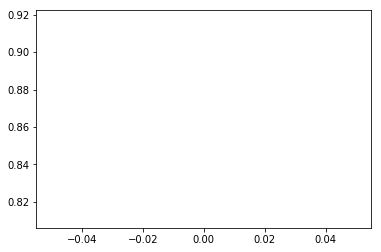

In [ ]:
trainIters(encoder1, decoder1,train_input, val_input,vocab, n_iters = 100000,patience = 1000, print_every=10, plot_every=200, learning_rate=1e-3)
torch.save(encoder1.state_dict(), 'keywords_encoder.params')
torch.save(decoder1.state_dict(), 'keywords_attn_decoder1.params')

In [21]:
a = 1

In [ ]:
a = {
                        "A": -1,
                        "B": -2,
                        "C": -3
                }

In [ ]:
for k,v in a.items():
    a.update({k:v+len(a)})
a

In [ ]:
# predict(Doc.text_to_idxs(np.array(["梦想"])))
predict(encoder1,decoder1,Doc.text_to_idxs("梦想希望"),vocab)
#predict(Doc.text_to_idxs(),encoder1,attn_decoder1)